1) Загрузка данных из Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1-QnB6EPbDpqWQHx2q_w6Va4wVqGpmCZj
To: /content/train.csv
100%|██████████| 461k/461k [00:00<00:00, 89.3MB/s]

Данные загружены. Показ первых строк:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



2) Визуализация топ-10 признаков по корреляции с таргетом...


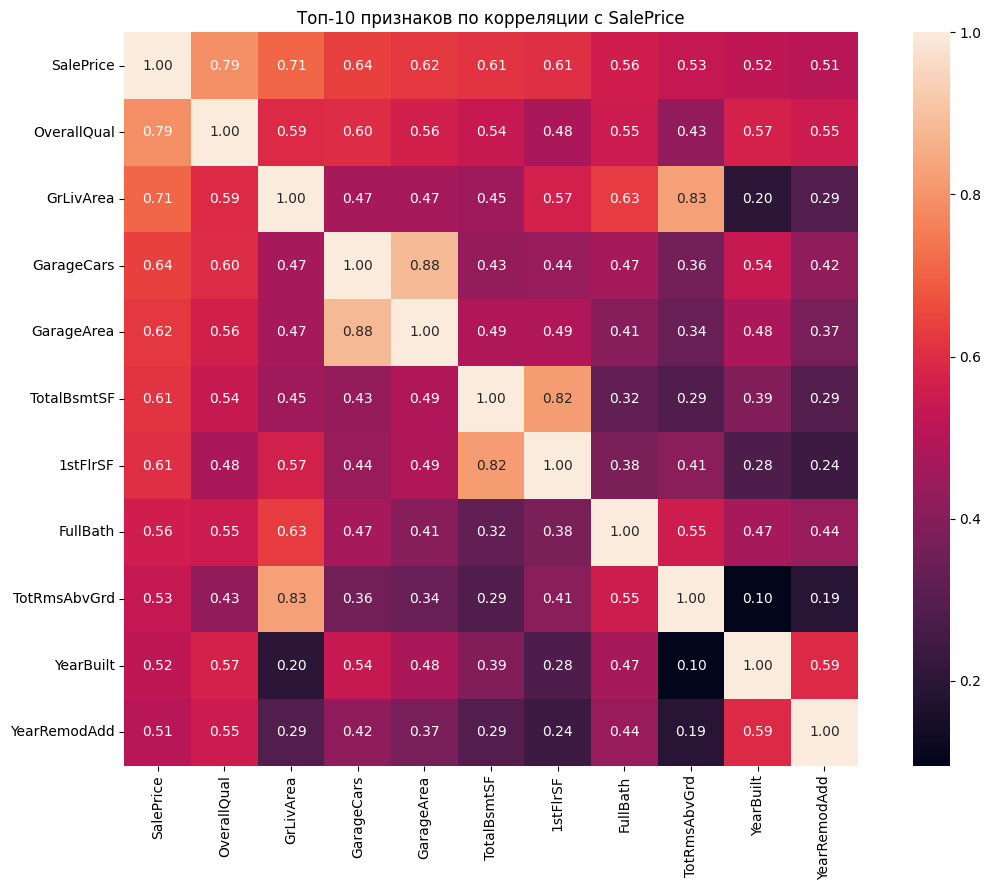


3) Подготовка данных: one-hot и StandardScaler...

4) Обучение и оценка XGBoost (все признаки: числовые + one-hot)...


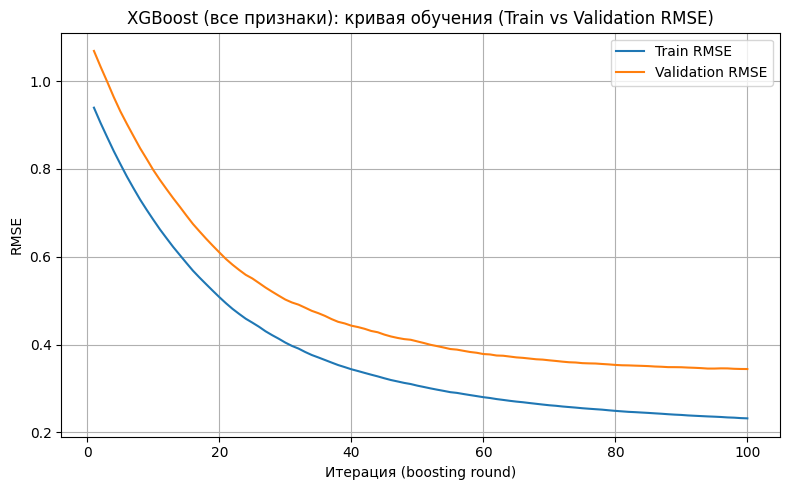

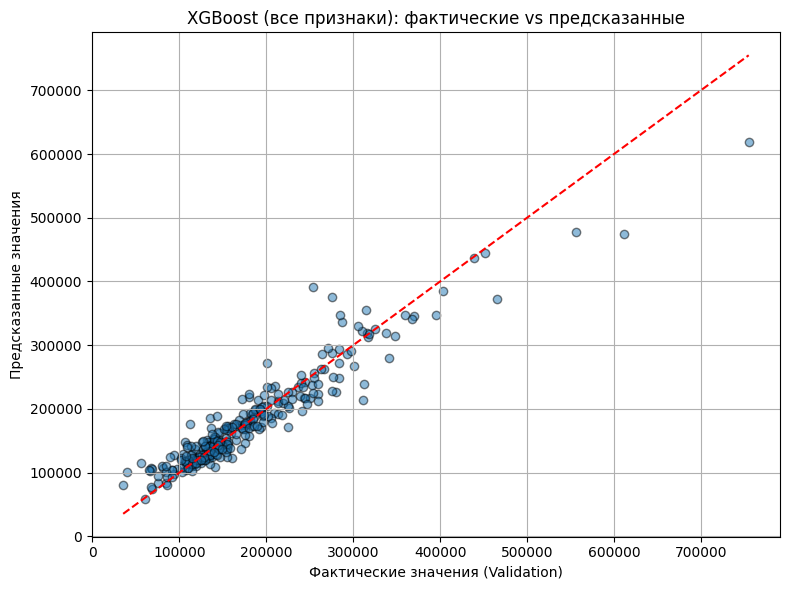

XGBoost (все признаки) метрики на валидации:
  MAE  : 17593.89
  MSE  : 747881002.56
  RMSE : 27347.41
  R²   : 0.9025
  MAPE : 11.18%

5) Обучение нейросети с L2-регуляризацией и Dropout (MAE loss)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7722 - mae: 0.4365 - val_loss: 0.5697 - val_mae: 0.3074
Epoch 2/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5780 - mae: 0.3252 - val_loss: 0.4859 - val_mae: 0.2585
Epoch 3/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5217 - mae: 0.3018 - val_loss: 0.4369 - val_mae: 0.2372
Epoch 4/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4926 - mae: 0.2992 - val_loss: 0.4354 - val_mae: 0.2590
Epoch 5/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4288 - mae: 0.2576 - val_loss: 0.4494 - val_mae: 0.2932
Epoch 6/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3915 - mae: 0.2395 - val_loss: 0.3854 - val_mae: 0.2456
Epoch 7/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3994 - mae: 0.2633 - val_loss: 0.3792 - val_mae: 0.2535
Epoch 8/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3666 - mae: 0.2441 - val_loss: 0.3577 - val_mae: 0.2445
Epoch 9/40
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

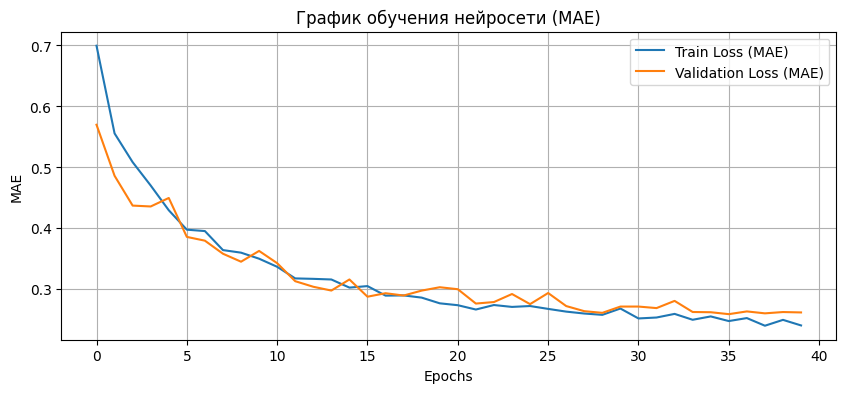

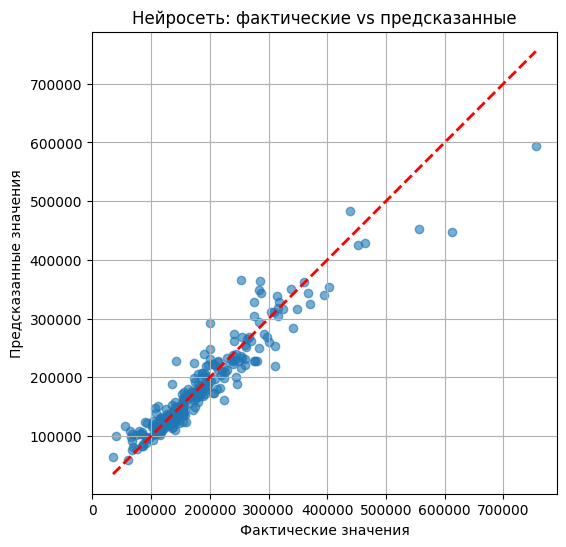

In [ ]:
!pip install gdown

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

import os
import random
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

def set_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Детерминированные операции TF

set_seed(1)

def run_full_pipeline(
    gdrive_id='1-QnB6EPbDpqWQHx2q_w6Va4wVqGpmCZj',
    correlation_target='SalePrice',
    xgb_iters=100,
    nn_epochs=40,
    nn_batch_size=8
):
    """
    Единая функция, выполняющая весь пайплайн:
      1) Загрузка данных из Google Drive (gdown).
      2) Визуализация топ-10 признаков по корреляции с целевой.
      3) Подготовка датасета: one-hot кодирование заданных категориальных столбцов,
         масштабирование признаков и таргета через StandardScaler.
      4) Обучение XGBoost с графиком Train/Validation RMSE и "фактические vs предсказанные".
      5) Обучение нейросети с L2-регуляризацией и Dropout (MAE loss), с графиками обучения и "фактические vs предсказанные".
      6) Возвращает два обученных объекта: (xgb_model, nn_model).

    Параметры:
      - gdrive_id: ID файла CSV на Google Drive (по умолчанию указан ID train.csv).
      - correlation_target: имя столбца с таргетом для корреляции (обычно 'SalePrice').
      - xgb_iters: число итераций (n_estimators) для XGBoost.
      - nn_epochs: число эпох для обучения нейросети.
      - nn_batch_size: размер batch для обучения нейросети.

    Возвращает:
      - xgb_model: обученный XGBRegressor.
      - nn_model: обученная Keras Sequential модель с L2-регуляризацией.
    """

    # ----------------------------------------
    # 1) Загрузка данных
    # ----------------------------------------
    print("1) Загрузка данных из Google Drive...")
    gdown.download(id=gdrive_id, output='train.csv', quiet=False)
    df = pd.read_csv('train.csv')
    print("Данные загружены. Показ первых строк:")
    display(df.head())

    # ----------------------------------------
    # 2) Визуализация топ-10 корреляции
    # ----------------------------------------
    print("\n2) Визуализация топ-10 признаков по корреляции с таргетом...")
    corrmat = df.corr(numeric_only=True)
    top_feats = corrmat.nlargest(11, correlation_target)[correlation_target].index
    cm = np.corrcoef(df[top_feats].values.T)

    plt.figure(figsize=(12, 9))
    sns.heatmap(
        cm,
        cbar=True, annot=True, square=True, fmt='.2f',
        annot_kws={'size': 10},
        yticklabels=top_feats.values, xticklabels=top_feats.values
    )
    plt.title(f'Топ-10 признаков по корреляции с {correlation_target}')
    plt.tight_layout()
    plt.show()

    # ----------------------------------------
    # 3) Подготовка данных для ML
    # ----------------------------------------
    print("\n3) Подготовка данных: one-hot и StandardScaler...")
    # Список категориальных столбцов и их отображения
    our_classes = [
        [0, {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}],
        [0, {'10 Very Excellent': 0, '9  Excellent': 1, '8  Very Good': 2, '7  Good': 3, '6  Above Average': 4,
             '5  Average': 5, '4  Below Average': 6, '3  Fair': 7, '2  Poor': 8, '1  Very Poor': 9}],
        [0, {'10 Very Excellent': 0, '9  Excellent': 1, '8  Very Good': 2, '7  Good': 3, '6  Above Average': 4,
             '5  Average': 5, '4  Below Average': 6, '3  Fair': 7, '2  Poor': 8, '1  Very Poor': 9}],
        [0, {'1Story': 0, '1.5Fin': 1, '1.5Unf': 2, '2Story': 3, '2.5Fin': 4, '2.5Unf': 5, 'SFoyer': 6, 'SLvl	Split Level': 7}],
        [0, {'1Fam': 0, '2FmCon': 1, 'Duplx': 2, 'TwnhsE': 3, 'TwnhsI': 4, '2.5Unf': 5}],
        [0, {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRNn': 3, 'RRAn': 4, 'PosN': 5, 'PosA': 6, 'RRNe': 7, 'RRAe': 8}],
        [0, {'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7,
             'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'Names': 12, 'NoRidge': 13, 'NPkVill': 14,
             'NridgHt': 15, 'NWAmes': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21,
             'StoneBr': 22, 'Timber': 23, 'Veenker': 24}],
        [0, {'Gtl': 0, 'Mod': 1, 'Sev': 2}],
        [0, {'Inside': 0, 'Corner': 1, 'CulDSac': 2, 'FR2': 3, 'FR3': 4}],
        [0, {'AllPub': 0, 'NoSewr': 1, 'NoSeWa': 2, 'ELO': 3}],
        [0, {'Lvl': 0, 'Bnk': 1, 'HLS': 2, 'Low': 3}],
        [0, {'10 Very Excellent': 0, '9  Excellent': 1, '8  Very Good': 2, '7  Good': 3, '6  Above Average': 4,
             '5  Average': 5, '4  Below Average': 6, '3  Fair': 7, '2  Poor': 8, '1  Very Poor': 9}],
    ]
    column_names = [
        'Functional', 'OverallCond', 'OverallQual', 'HouseStyle',
        'BldgType', 'Condition1', 'Neighborhood', 'LandSlope',
        'LotConfig', 'Utilities', 'LandContour'
    ]
    # Заполняем our_classes[·][0] = число классов
    for class_desc in our_classes:
        class_desc[0] = max(class_desc[1].values()) + 1

    # One-hot кодирование
    one_hot_encoded = []
    for class_desc, col in zip(our_classes, column_names):
        mapping = class_desc[1]
        num_classes = class_desc[0]
        df[col + '_cat'] = df[col].map(mapping).fillna(0).astype(int)
        encoded = to_categorical(df[col + '_cat'], num_classes=num_classes)
        df_enc = pd.DataFrame(encoded, columns=[f"{col}_{i}" for i in range(num_classes)], index=df.index)
        one_hot_encoded.append(df_enc)
    df_one_hot = pd.concat(one_hot_encoded, axis=1)

    # Числовые признаки и таргет
    numeric_feats = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
                     'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
                     'YearBuilt', 'YearRemodAdd']
    target = 'SalePrice'

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    df_scaled_features = scaler_X.fit_transform(df[numeric_feats])
    df_scaled_target   = scaler_y.fit_transform(df[[target]])

    df_scaled_feats_df = pd.DataFrame(df_scaled_features, columns=numeric_feats, index=df.index)
    df_features = pd.concat([df_one_hot, df_scaled_feats_df], axis=1)

    X = df_features.to_numpy()
    y = df_scaled_target  # (n_samples, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ----------------------------------------
    # 4) Обучение и оценка XGBoost (числовые + one-hot признаки)
    # ----------------------------------------
    print("\n4) Обучение и оценка XGBoost (все признаки: числовые + one-hot)...")

    xgb_model = XGBRegressor(
        random_state=42,
        n_estimators=xgb_iters,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='rmse'
    )
    xgb_model.fit(
        X_train, y_train.ravel(),
        eval_set=[(X_train, y_train.ravel()), (X_test, y_test.ravel())],
        verbose=False
    )

    xgb_results = xgb_model.evals_result()
    train_rmse = xgb_results['validation_0']['rmse']
    val_rmse   = xgb_results['validation_1']['rmse']
    epochs = range(1, len(train_rmse) + 1)

    # График RMSE
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_rmse, label='Train RMSE')
    plt.plot(epochs, val_rmse,   label='Validation RMSE')
    plt.xlabel("Итерация (boosting round)")
    plt.ylabel("RMSE")
    plt.title("XGBoost (все признаки): кривая обучения (Train vs Validation RMSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Предсказания и обратное преобразование
    y_pred_scaled = xgb_model.predict(X_test).reshape(-1, 1)
    y_true_scaled = y_test.reshape(-1, 1)
    y_pred_xgb = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true_xgb = scaler_y.inverse_transform(y_true_scaled).flatten()

    # Метрики
    mae_xgb  = mean_absolute_error(y_true_xgb, y_pred_xgb)
    mse_xgb  = mean_squared_error(y_true_xgb, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb   = r2_score(y_true_xgb, y_pred_xgb)
    mape_xgb = np.mean(np.abs((y_true_xgb - y_pred_xgb) / y_true_xgb)) * 100

    # График «Фактические vs Предсказанные»
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_xgb, y_pred_xgb, alpha=0.5, edgecolors='k')
    plt.plot([y_true_xgb.min(), y_true_xgb.max()], [y_true_xgb.min(), y_true_xgb.max()], 'r--')
    plt.xlabel("Фактические значения (Validation)")
    plt.ylabel("Предсказанные значения")
    plt.title("XGBoost (все признаки): фактические vs предсказанные")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"XGBoost (все признаки) метрики на валидации:")
    print(f"  MAE  : {mae_xgb:.2f}")
    print(f"  MSE  : {mse_xgb:.2f}")
    print(f"  RMSE : {rmse_xgb:.2f}")
    print(f"  R²   : {r2_xgb:.4f}")
    print(f"  MAPE : {mape_xgb:.2f}%")


    # ----------------------------------------
    # 5) Обучение и оценка нейросети (L2 + Dropout)
    # ----------------------------------------
    print("\n5) Обучение нейросети с L2-регуляризацией и Dropout (MAE loss)...")
    nn_model = Sequential([
        Dense(256, activation='relu',
              input_shape=(X_train.shape[1],),
              kernel_regularizer=l2(0.001)
        ),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    history = nn_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=nn_epochs,
        batch_size=nn_batch_size,
        verbose=1
    )

    # Предсказания (масштабированные)
    y_pred_scaled = nn_model.predict(X_test).reshape(-1, 1)
    y_true_scaled = y_test.reshape(-1, 1)
    y_pred_nn = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true_nn = scaler_y.inverse_transform(y_true_scaled).flatten()

    # Метрики (нейросеть)
    mae_nn  = mean_absolute_error(y_true_nn, y_pred_nn)
    mse_nn  = mean_squared_error(y_true_nn, y_pred_nn)
    rmse_nn = np.sqrt(mse_nn)
    r2_nn   = r2_score(y_true_nn, y_pred_nn)
    mask_nn = y_true_nn != 0
    mape_nn = np.mean(np.abs((y_true_nn[mask_nn] - y_pred_nn[mask_nn]) / y_true_nn[mask_nn])) * 100

    print(f"\nНейросеть (L2 + Dropout) метрики:")
    print(f"  MAE  : {mae_nn:.2f}")
    print(f"  MSE  : {mse_nn:.2f}")
    print(f"  RMSE : {rmse_nn:.2f}")
    print(f"  R²   : {r2_nn:.4f}")
    print(f"  MAPE : {mape_nn:.2f}%")

    # График обучения (MAE loss)
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'],   label='Train Loss (MAE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('График обучения нейросети (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # График «Фактические vs Предсказанные» (нейросеть)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true_nn, y_pred_nn, alpha=0.6)
    mn_nn = min(y_true_nn.min(), y_pred_nn.min())
    mx_nn = max(y_true_nn.max(), y_pred_nn.max())
    plt.plot([mn_nn, mx_nn], [mn_nn, mx_nn], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Нейросеть: фактические vs предсказанные')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    return xgb_model, nn_model

xgb_model, nn_model = run_full_pipeline(
    gdrive_id='1-QnB6EPbDpqWQHx2q_w6Va4wVqGpmCZj',
    correlation_target='SalePrice',
    xgb_iters=100,
    nn_epochs=40,
    nn_batch_size=8
)


В ходе эксперимента была проведена серия сравнений между классическими алгоритмами машинного обучения (XGBoost) и нейронными сетями, построенными с использованием Tensorflow/Keras.
При решении задачи регрессии на датасете Ames Housing (с масштабированием числовых признаков и one-hot кодированием категориальных) нейронные сети с регуляризацией l2 показали MAE, худшее в лучшем случае 100 - (XGBoost_MAE/NN_l2_MAE)*100 на 3,8695%, чем у XGBoost.

При этом построение нейросети требует существенно больше шагов: настройки архитектуры, выбора функции потерь, регуляризации, контроля переобучения, и зачастую приводит к пробам и ошибкам.
В отличие от этого, XGBoost и Random Forest обеспечивают стабильное качество с минимальной настройкой, особенно на табличных данных.

Вывод: классические модели ML — особенно XGBoost — остаются эффективным и оправданным решением для задач линейной регрессии, и преждевременно списывать их со счёта не стоит.